In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import math
%matplotlib inline

# Helper Function

In [2]:
def weighted_img(img, initial_img, α=1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """

    return cv2.addWeighted(initial_img, α, img, β, γ)

# Step1: Calibration camera

In [3]:
def camera_calibrating():

    images = glob.glob("camera_cal/calibration*.jpg")
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    for  fname in images:
        
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    imagex = mpimg.imread("camera_cal/calibration3.jpg")
    
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,imagex.shape[1::-1],None,None)
    
    return (mtx,dist)

#  Example of applying distortion correction to one of the chessboard images

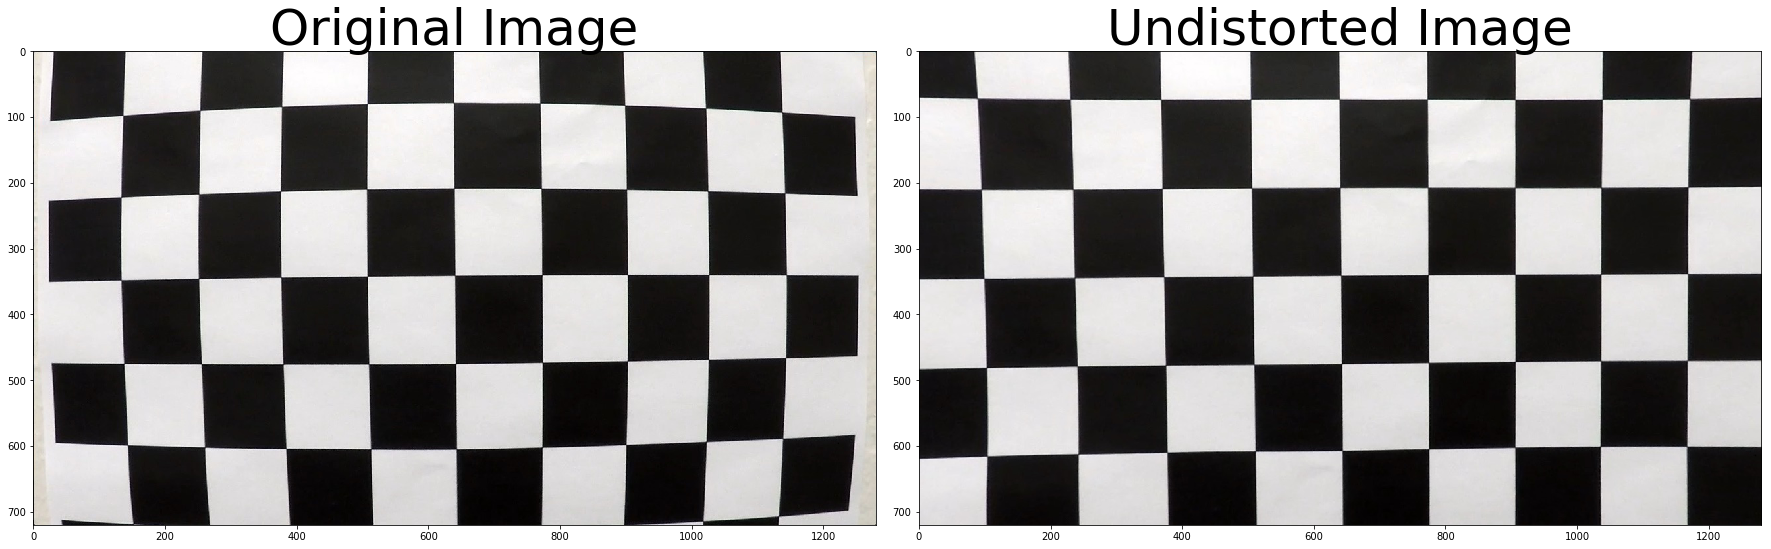

In [18]:
test_chessboard = mpimg.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(test_chessboard,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_chessboard)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Example of applying distortion correction to one of the test images

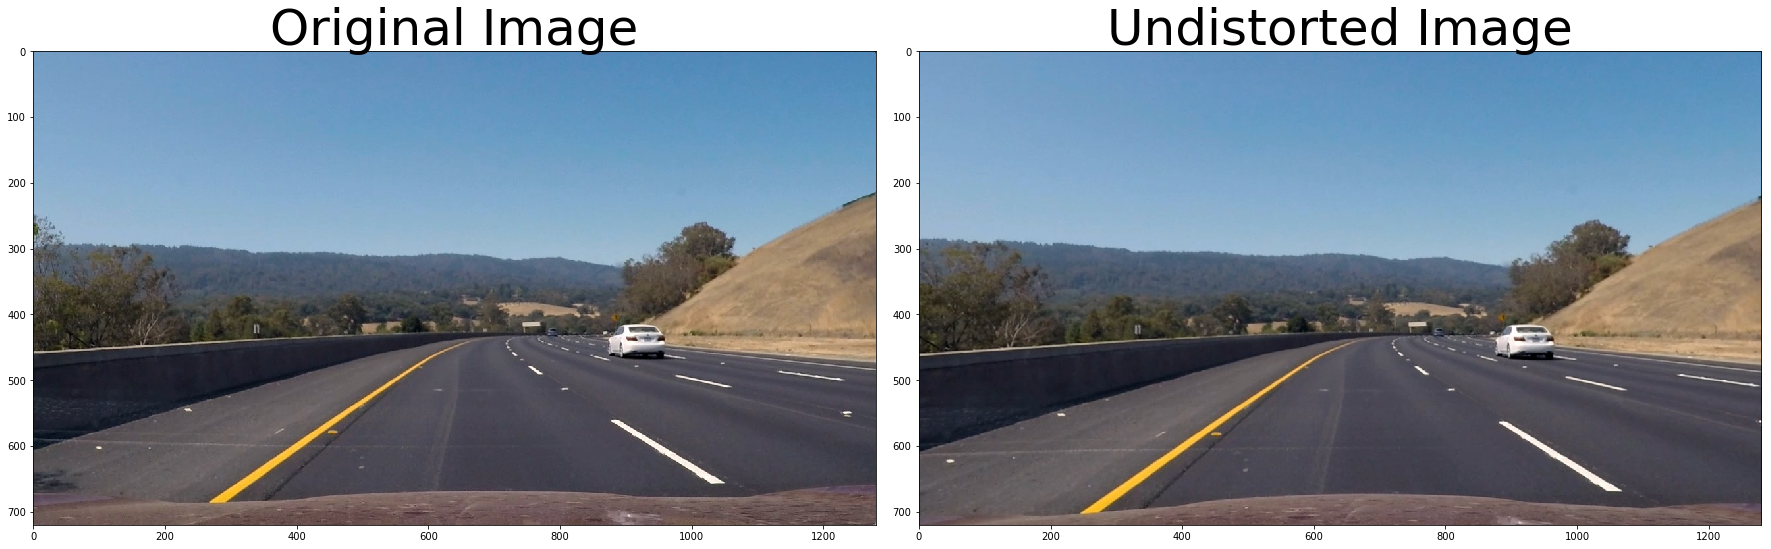

In [19]:
test_image = mpimg.imread("test_images/test3.jpg")
undist = cv2.undistort(test_image,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step2: perspective transform

In [6]:
def corners_unwarp(src_point, mtx, dist):

    src = np.float32(src_point)


    dst = np.float32([[280, 490], [1000, 490],[1000, 718],[280, 718]])

    M = cv2.getPerspectiveTransform(src, dst)

    M_back = cv2.getPerspectiveTransform(dst, src)
    

 
    return M,M_back

# Step3 Gradients and Color Spaces

In [7]:
def GradientAndColor(img, s_thresh=(170, 255), sx_thresh=(20, 100),orient = 'x'):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    mtg_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_mtgsobel = np.uint8(255*mtg_sobel/np.max(mtg_sobel))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(sobelx)
    if orient =='x':
     sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    elif orient == 'y':
     sxbinary[(scaled_sobely >= sx_thresh[0]) & (scaled_sobely <= sx_thresh[1])] = 1
    elif orient == 'm':
     sxbinary[(scaled_mtgsobel >= sx_thresh[0]) & (scaled_mtgsobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

# option: show histgram

In [8]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Step4 Sliding Window

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    lane_center = leftx_base + (rightx_base - leftx_base) * 0.5
    car_center = midpoint
    
    distance_to_center =  (car_center - lane_center) * xm_per_pix

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img,distance_to_center


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img,distance_to_center = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit,left_fit_meters,right_fit_meters,leftx,lefty,rightx,righty,distance_to_center
    #return out_img

# Step5 back to the origin image

In [10]:
def draw_field(wraped_image,left_fitx,right_fitx,ploty):
    
    window_img = np.zeros_like(wraped_image)
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    window_between_line = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([window_between_line]), (0,255, 0))
    
    result = cv2.addWeighted(wraped_image, 1, window_img, 0.3, 0)
    return result

# Option measure_curvature_pixels

In [11]:
def measure_curvature_pixels(ploty,left_fit_meters,right_fit_meters):

    y_eval_meters = np.max(ploty)*ym_per_pix
    

    left_curverad = ((1+(2*left_fit_meters[0]*y_eval_meters + left_fit_meters[1])**2)**(1.5))/(abs(2*left_fit_meters[0]))

    right_curverad = ((1+(2*right_fit_meters[0]*y_eval_meters + right_fit_meters[1])**2)**(1.5))/(abs(2*right_fit_meters[0]))

    
    return left_curverad, right_curverad

In [12]:
nx = 9
ny = 6
xm_per_pix = 3.7/720
ym_per_pix = 30/720
(mtx,dist) = camera_calibrating()
src_point = [[540, 488], [746, 488],[1100, 718],[212, 718]]
M , M_back = corners_unwarp(src_point, mtx, dist)

In [13]:
def pipeline(image):
#test_img = mpimg.imread("test_images/test6.jpg")
 font01=cv2.FONT_HERSHEY_SIMPLEX
 img_size = (image.shape[1], image.shape[0])
 undist = cv2.undistort(image,mtx,dist,None,mtx)
 grad_img = GradientAndColor(undist,orient='x')
 binary_warped = cv2.warpPerspective(grad_img, M, img_size)
    

 (out_img,left_fitx,right_fitx,ploty,left_fit,right_fit,left_fit_meters,right_fit_meters,leftx,lefty,rightx,righty,distance_to_center) = fit_polynomial(binary_warped)
   
 ## Visualization
 lane_with_field = draw_field((out_img).astype(np.uint8),left_fitx,right_fitx,ploty)
 #plt.imshow(lane_with_field,cmap='gray')
 
 wraped_back = (cv2.warpPerspective(lane_with_field, M_back, img_size)).astype(np.uint8)
 
 #plt.imshow(wraped_back)
 orign_caled = weighted_img(wraped_back, undist) 

    
 
 DISTANCE_TO_CENTER = str((round(float(distance_to_center),2)))
 
 
 (radius_left,radius_right) = measure_curvature_pixels(ploty,left_fit_meters,right_fit_meters)
 Radius = str(int((radius_left+radius_right)*0.5))
 
 cv2.putText(orign_caled, "Radius of Curvature ="+Radius+"(m)",(10,100),font01,2,(0,255,255),4)
 cv2.putText(orign_caled, "Vehicle is "+DISTANCE_TO_CENTER,(10,150),font01,2,(0,255,255),4)
 cv2.putText(orign_caled, "m left of center",(550,150),font01,2,(0,255,255),4)

 
 return orign_caled

# Test on video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

In [16]:
white_output = 'test_video_5seconds.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(18,1)
clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_5seconds.mp4
[MoviePy] Writing video test_video_5seconds.mp4


 99%|█████████▉| 125/126 [00:31<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_5seconds.mp4 

CPU times: user 17.2 s, sys: 3.04 s, total: 20.3 s
Wall time: 35 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))